In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Tutorial de modelos VARX

En este tutorial, desarrollaremos un ejemplo de los modelos VARX(p,s). Emplearemos cuatro series de tiempo, para ejemplificar las relaciones endógenas y exógenas de un sistema VARX.
Las variables son:
* Precios regulares de la gasolina.
* Precios de gasolina para la calefacción.
* Precios del crudo.
* Precios del gas natural.

Usaremeos la librería de MTS previamente empleada para los modelos VAR. 

**Contenido**
1. [Importación de librerías requeridas](#1)
1. [Importación de datos](#2)
1. [Visualización de las series](#3)
1. [Determinación del nivel autorregresivo](#4)
1. [ Modelo VARX](#5)
1. [Modelo VARX refinado](#6)
1. [Predicción](#7)

<a id="1"></a> <br>
## 1. Librerías requeridas
Como es usual, importamos las librerías que emplearemos en este tutorial.

In [17]:
# Importamos las librerías
library(MTS)
library(tseries)
library(Metrics)
library(dplyr)
library(forecast)
options(warn = - 1) 

<a id="2"></a> <br>
### 2. Datos
Importamos los datos requeridos.

In [35]:
## Los datos contienen los precios de los activos en cuatro columnas, dos para variables exógenas y otros dos para endógenas.
datos=read.table("/kaggle/input/multigasoil/multi-gasoil.txt",header=T)
#Podemos visualizar los datos:
head(datos)
tail(datos)
#Removemos las columnas de fechas:
vars=datos[,3:6]
## Renombramos para facilidad de análisis posterior las variables:
colnames(vars) <- c("z1:conv","z2:hoil","x1:crude_oilp","x2:nat_gasp")
head(vars)

,year,Month,conv,heatoil,oilprice,gasprice
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1993,11,1.066,0.502,16.699,2.32
2,1993,12,1.014,0.435,14.510,2.09
3,1994,1,0.998,0.499,15.000,2.41
4,1994,2,1.009,0.557,14.780,2.59
5,1994,3,1.008,0.492,14.660,2.08
6,1994,4,1.027,0.479,16.380,2.04


,year,Month,conv,heatoil,oilprice,gasprice
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
221,2012,3,3.774,3.217,106.19,2.16
222,2012,4,3.837,3.150,103.33,1.95
223,2012,5,3.643,2.913,94.70,2.43
224,2012,6,3.465,2.619,82.41,2.46
225,2012,7,3.379,2.813,87.93,2.96
226,2012,8,3.668,3.045,94.16,2.84


,z1:conv,z2:hoil,x1:crude_oilp,x2:nat_gasp
,<dbl>,<dbl>,<dbl>,<dbl>
1,1.066,0.502,16.699,2.32
2,1.014,0.435,14.510,2.09
3,0.998,0.499,15.000,2.41
4,1.009,0.557,14.780,2.59
5,1.008,0.492,14.660,2.08
6,1.027,0.479,16.380,2.04


<a id="3"></a> <br>
### 3. Visualización de las series

Podemos emplear los datos de fechas para generar un nuevo objeto que combine el año con el mes. Para ello, tomamos la primera columna del año y le sumamos la columna del mes, siendo este último dividido en la fracción del año; esto es, dividiéndola entre 12.

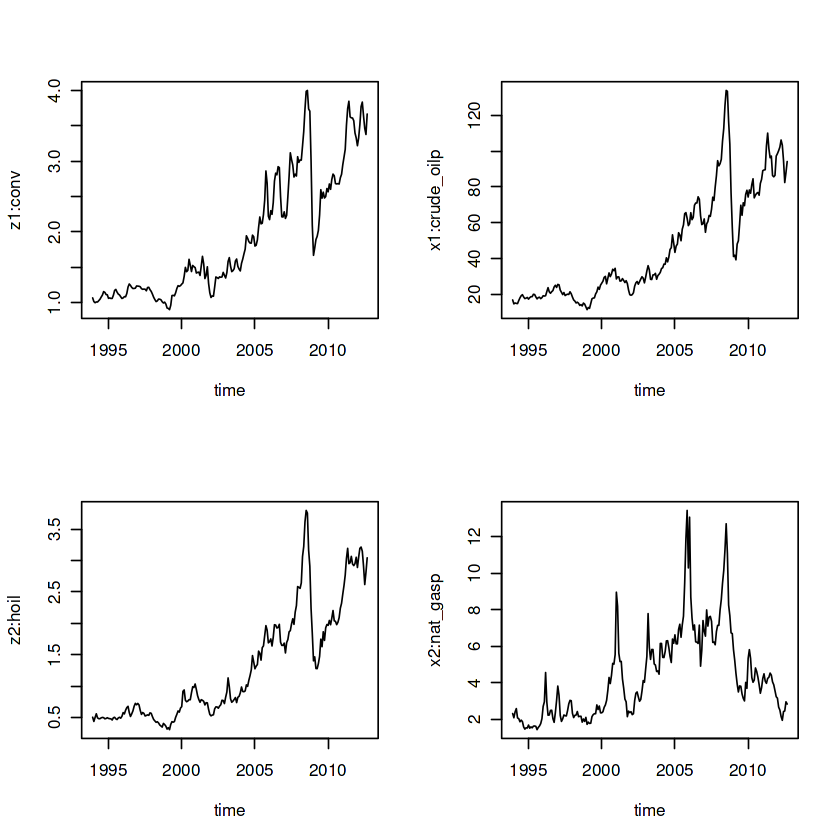

In [36]:
# Generamos un conjunto de datos a partir de la primera columna de año y a esa le sumamos la columna de mes, dividiéndola entre 12, para que sume esa fracción del año.
ejex=datos[,1]+(datos[,2]/12)
#Y graficamos las cuatro series mediante la función MTSplot
MTSplot(vars,ejex)

Como podemos observar, hay comportamientos similares en las series de precios del gas convencional, de calefacción y el crudo. 

In [37]:
# Seleccionamos las variables endógenas y exógenas: zt, xt, respectivamente.
zt=vars[,1:2]
head(zt)
xt=vars[,3:4]
head(xt)

,z1:conv,z2:hoil
,<dbl>,<dbl>
1,1.066,0.502
2,1.014,0.435
3,0.998,0.499
4,1.009,0.557
5,1.008,0.492
6,1.027,0.479


,x1:crude_oilp,x2:nat_gasp
,<dbl>,<dbl>
1,16.699,2.32
2,14.510,2.09
3,15.000,2.41
4,14.780,2.59
5,14.660,2.08
6,16.380,2.04


<a id="4"></a> <br>
### 4. Determinación del nivel autorregresivo
A continuación, determinamos el nivel autorregresivo del conjutno de variables. Se procede por calcular primeramente, el nivel p o autorregresivo de cada conjunto o tipo de variables y luego, estos parámetros se suministran en la función de determinación del modelo VARX.

In [39]:
## VAR order: Para cada tipo de variables, se determina el nivel p:
VARorder(zt)
VARorder(xt)   

selected order: aic =  11 
selected order: bic =  2 
selected order: hq =  11 
Summary table:  
       p     AIC     BIC      HQ     M(p) p-value
 [1,]  0 -4.0481 -4.0481 -4.0481   0.0000  0.0000
 [2,]  1 -8.6871 -8.6265 -8.6626 979.2772  0.0000
 [3,]  2 -9.0847 -8.9637 -9.0359  89.8604  0.0000
 [4,]  3 -9.1417 -8.9601 -9.0684  18.9893  0.0008
 [5,]  4 -9.1252 -8.8830 -9.0274   3.8288  0.4297
 [6,]  5 -9.1302 -8.8275 -9.0080   8.1411  0.0865
 [7,]  6 -9.1840 -8.8207 -9.0374  17.8015  0.0013
 [8,]  7 -9.1574 -8.7336 -8.9864   1.7373  0.7839
 [9,]  8 -9.2060 -8.7216 -9.0105  16.4152  0.0025
[10,]  9 -9.2366 -8.6918 -9.0167  12.7826  0.0124
[11,] 10 -9.3124 -8.7070 -9.0681  21.2965  0.0003
[12,] 11 -9.3394 -8.6735 -9.0707  11.8239  0.0187
[13,] 12 -9.3205 -8.5940 -9.0273   3.0860  0.5435
[14,] 13 -9.3131 -8.5261 -8.9955   5.1917  0.2682
selected order: aic =  8 
selected order: bic =  2 
selected order: hq =  2 
Summary table:  
       p    AIC    BIC     HQ      M(p) p-value
 [1,]  0 8.2

A partir de los resultados obtenidos, se define que el orden regresivo para las variables endógenas es de 3 y un máximo de 11 y de las exógenas es de 2. Con ello, procedemos con la funcón VARXorder.

In [40]:
## Función VARX order:
VARXorder(zt,xt,maxp=11,maxm=2) 

selected order(p,s): aic =  11 1 
selected order(p,s): bic =  2 1 
selected order(p,s): hq =  2 1 


A partir de estos resultados, podemos identificar que la combinación más votada y simple de rezagos es el VARX(2,1).
Con ello, ingresamos estos parámetros a la función de determinación del orden regresivo en el modelo VARX, que genera un modelo VARX(2,1):

<a id="5"></a> <br>
### 5. Modelo VARX
A partir de las especificaciones anteriores, desarrollamos el modelo VARX.

In [41]:
## La función VARX requiere primero de la matriz de variables endógenas o zt y posteriormente, de las exógenas, xt.
m1=VARX(zt,2,xt,1)

constant term:  
est:  0.1817 -0.017 
 se:  0.0295 0.0186 
AR( 1 ) matrix 
        z1:conv z2:hoil
z1:conv   1.041   0.169
z2:hoil   0.005   0.844
standard errors 
      [,1] [,2]
[1,] 0.059 0.08
[2,] 0.037 0.05
AR( 2 ) matrix 
        z1:conv z2:hoil
z1:conv  -0.322  -0.008
z2:hoil   0.014   0.012
standard errors 
      [,1]  [,2]
[1,] 0.056 0.068
[2,] 0.035 0.043
Coefficients of exogenous 
lag- 0  coefficient matrix 
        x1:crude_oilp x2:nat_gasp
z1:conv         0.018       0.010
z2:hoil         0.024       0.026
standard errors 
      [,1]  [,2]
[1,] 0.001 0.007
[2,] 0.001 0.004
lag- 1  coefficient matrix 
        x1:crude_oilp x2:nat_gasp
z1:conv        -0.015      -0.012
z2:hoil        -0.019      -0.029
standard errors 
      [,1]  [,2]
[1,] 0.002 0.007
[2,] 0.001 0.004
Residual Covariance Matrix 
        z1:conv z2:hoil
z1:conv 0.00671 0.00104
z2:hoil 0.00104 0.00267
Information criteria:  
AIC:  -10.83396 
BIC:  -10.55981 


[1] "Covariance matrix:"
        z1:conv z2:hoil
z1:conv 0.00674 0.00105
z2:hoil 0.00105 0.00268
CCM at lag:  0 
      [,1]  [,2]
[1,] 1.000 0.247
[2,] 0.247 1.000
Simplified matrix: 
CCM at lag:  1 
. . 
. . 
CCM at lag:  2 
. . 
. . 
CCM at lag:  3 
. . 
- . 
CCM at lag:  4 
+ . 
. . 
CCM at lag:  5 
. . 
. . 
CCM at lag:  6 
. . 
. + 
CCM at lag:  7 
. + 
. . 
CCM at lag:  8 
. - 
. . 
CCM at lag:  9 
. . 
. . 
CCM at lag:  10 
. . 
. . 
CCM at lag:  11 
. . 
. . 
CCM at lag:  12 
. . 
. . 
CCM at lag:  13 
. . 
. . 
CCM at lag:  14 
. . 
. . 
CCM at lag:  15 
. . 
. . 
CCM at lag:  16 
. . 
. . 
CCM at lag:  17 
. . 
. . 
CCM at lag:  18 
. . 
. . 
CCM at lag:  19 
. . 
. . 
CCM at lag:  20 
. . 
+ . 
CCM at lag:  21 
. . 
. . 
CCM at lag:  22 
. . 
. . 
CCM at lag:  23 
. . 
. . 
CCM at lag:  24 
. . 
. . 


Hit Enter for p-value plot of individual ccm:  


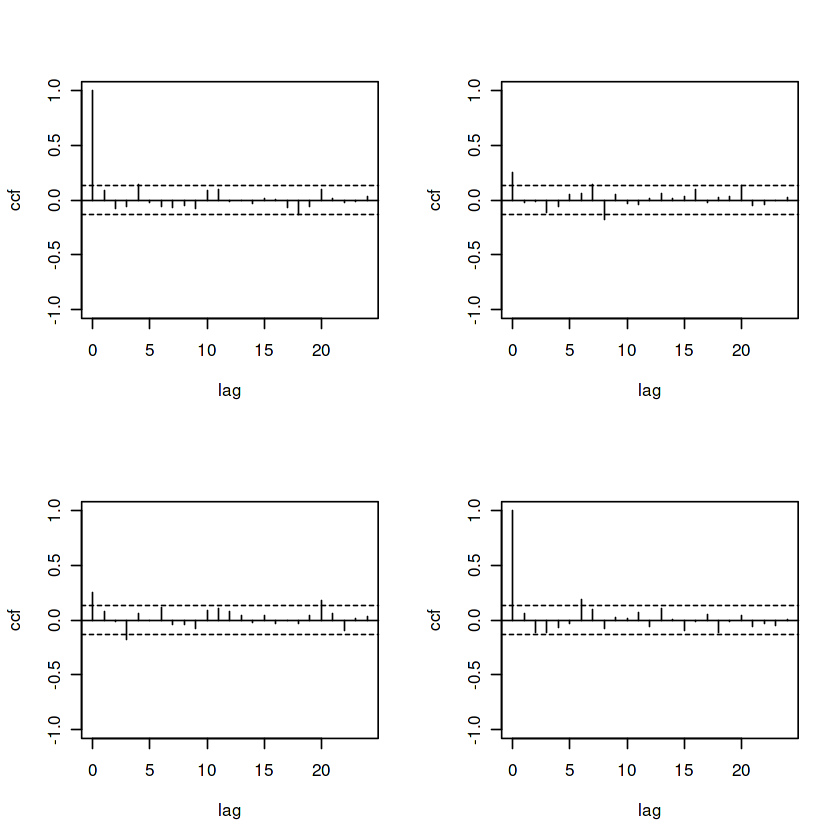

Hit Enter to compute MQ-statistics: 
Ljung-Box Statistics:  
         m       Q(m)     df    p-value
 [1,]   1.00      3.49    4.00     0.48
 [2,]   2.00      7.81    8.00     0.45
 [3,]   3.00     18.14   12.00     0.11
 [4,]   4.00     26.23   16.00     0.05
 [5,]   5.00     27.52   20.00     0.12
 [6,]   6.00     39.01   24.00     0.03
 [7,]   7.00     47.77   28.00     0.01
 [8,]   8.00     55.25   32.00     0.01
 [9,]   9.00     58.68   36.00     0.01
[10,]  10.00     62.30   40.00     0.01
[11,]  11.00     68.25   44.00     0.01
[12,]  12.00     71.96   48.00     0.01
[13,]  13.00     75.26   52.00     0.02
[14,]  14.00     75.73   56.00     0.04
[15,]  15.00     79.70   60.00     0.05
[16,]  16.00     82.63   64.00     0.06
[17,]  17.00     84.60   68.00     0.08
[18,]  18.00     93.56   72.00     0.04
[19,]  19.00     96.35   76.00     0.06
[20,]  20.00    108.14   80.00     0.02
[21,]  21.00    110.91   84.00     0.03
[22,]  22.00    113.63   88.00     0.03
[23,]  23.00    114

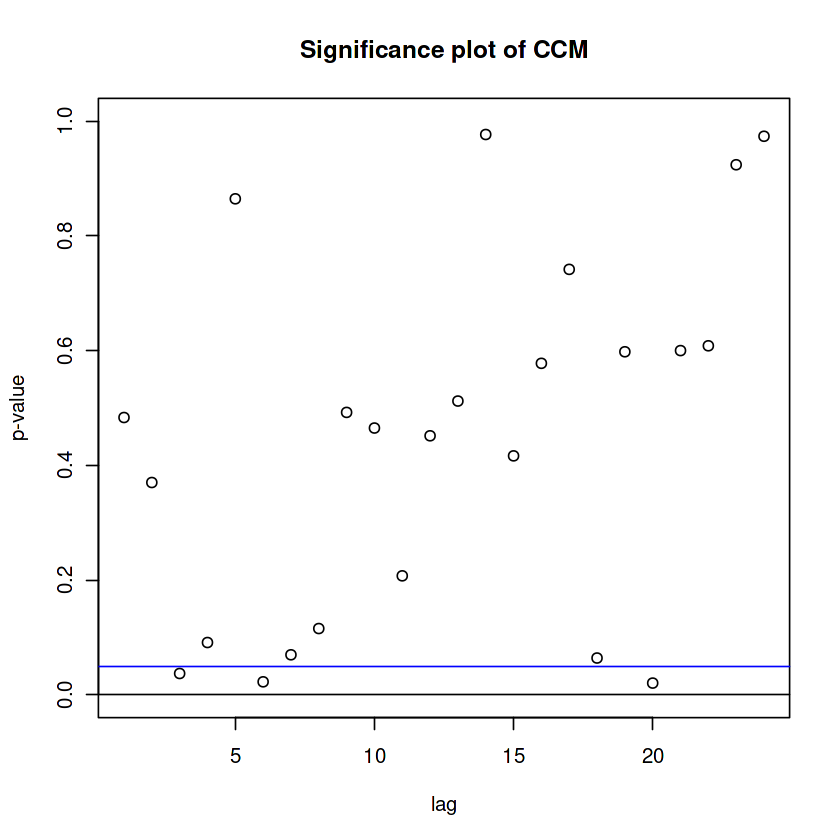

Hit Enter to obtain residual plots: 


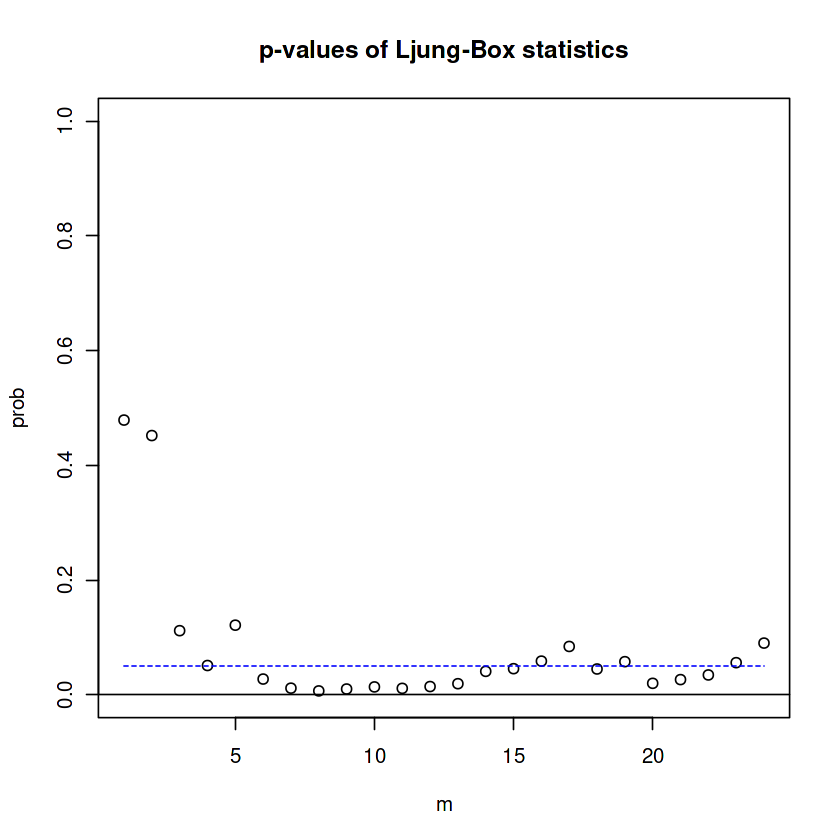

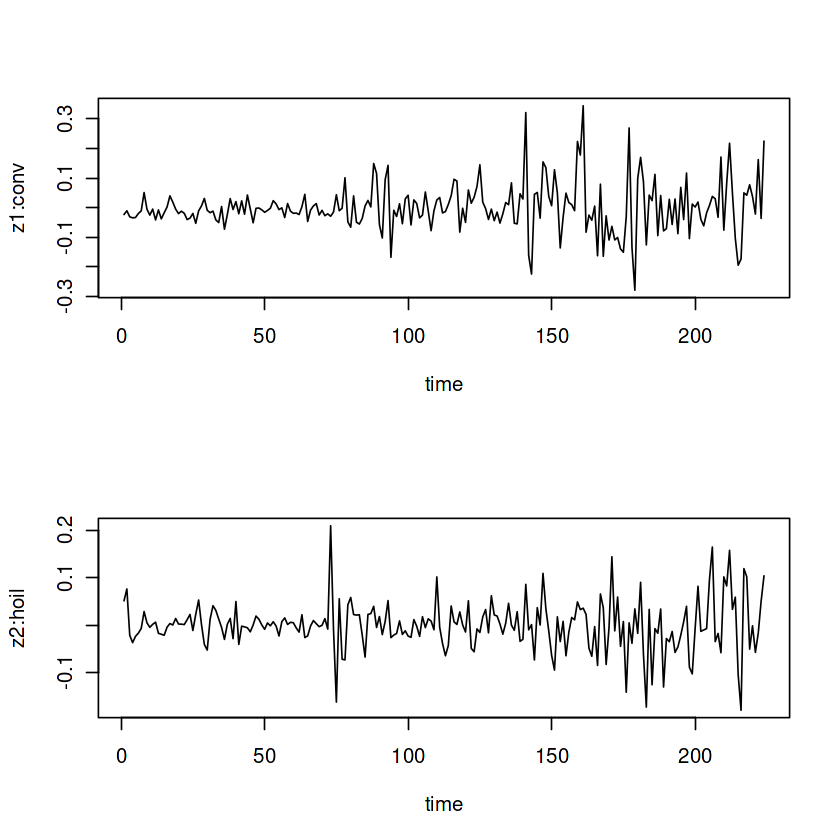

In [42]:
## Estimamos efectos inmediatos (CCM at lag 0) y residuales:
MTSdiag(m1)

Como podemos observar, dicha especificación del modelo, genera algunos residuales con correlaciones seriales significativas que podemos observar en las gráficas de los p-valores en las pruebas de Ljung Box (p valore del tercer rezago debajo de la línea de significancia). Por ello, se opta por un refinamiento del mismo.
Dicho refinamiento se puede realizar mediante la librería de MTS, a través de la función refVARX(). Por otro lado, no tenemos efectos inmediatos en el sistema (p-valores arriba de la significancia).

<a id="6"></a> <br>
### 6. Modelo VARX refinado
Procedemos por tanto a la aplicación de una función de refinamiento al modelo anterior.

In [43]:
# la función de refinamiento es refVARX:
m1_ref=refVARX(m1) 

constant term:  
est:  0.1828 0 
 se:  0.028 1 
AR( 1 ) matrix 
      [,1]  [,2]
[1,] 1.044 0.162
[2,] 0.000 0.873
standard errors 
      [,1]  [,2]
[1,] 0.054 0.056
[2,] 1.000 0.031
AR( 2 ) matrix 
       [,1] [,2]
[1,] -0.327    0
[2,]  0.000    0
standard errors 
     [,1] [,2]
[1,] 0.04    1
[2,] 1.00    1
Coefficients of exogenous 
lag- 0  coefficient matrix 
      [,1]  [,2]
[1,] 0.018 0.010
[2,] 0.023 0.026
standard errors 
      [,1]  [,2]
[1,] 0.001 0.007
[2,] 0.001 0.004
lag- 1  coefficient matrix 
       [,1]   [,2]
[1,] -0.015 -0.012
[2,] -0.019 -0.029
standard errors 
      [,1]  [,2]
[1,] 0.002 0.007
[2,] 0.001 0.004
Residual Covariance Matrix 
        z1:conv z2:hoil
z1:conv 0.00671 0.00104
z2:hoil 0.00104 0.00269
Information criteria:  
AIC:  -10.87015 
BIC:  -10.67216 


[1] "Covariance matrix:"
        z1:conv z2:hoil
z1:conv 0.00674 0.00105
z2:hoil 0.00105 0.00270
CCM at lag:  0 
      [,1]  [,2]
[1,] 1.000 0.246
[2,] 0.246 1.000
Simplified matrix: 
CCM at lag:  1 
. . 
. . 
CCM at lag:  2 
. . 
. . 
CCM at lag:  3 
. . 
- . 
CCM at lag:  4 
+ . 
. . 
CCM at lag:  5 
. . 
. . 
CCM at lag:  6 
. . 
. + 
CCM at lag:  7 
. + 
. . 
CCM at lag:  8 
. - 
. . 
CCM at lag:  9 
. . 
. . 
CCM at lag:  10 
. . 
. . 
CCM at lag:  11 
. . 
. . 
CCM at lag:  12 
. . 
. . 
CCM at lag:  13 
. . 
. . 
CCM at lag:  14 
. . 
. . 
CCM at lag:  15 
. . 
. . 
CCM at lag:  16 
. . 
. . 
CCM at lag:  17 
. . 
. . 
CCM at lag:  18 
. . 
. . 
CCM at lag:  19 
. . 
. . 
CCM at lag:  20 
. . 
+ . 
CCM at lag:  21 
. . 
. . 
CCM at lag:  22 
. . 
. . 
CCM at lag:  23 
. . 
. . 
CCM at lag:  24 
. . 
. . 


Hit Enter for p-value plot of individual ccm:  


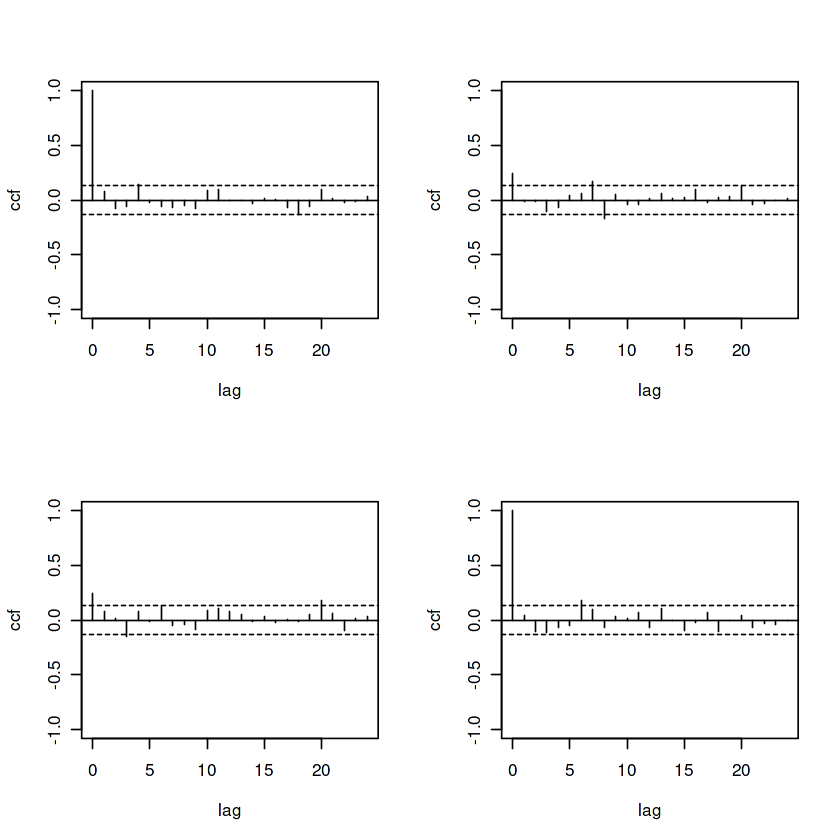

Hit Enter to compute MQ-statistics: 
Ljung-Box Statistics:  
         m       Q(m)     df    p-value
 [1,]   1.00      2.62    4.00     0.62
 [2,]   2.00      7.13    8.00     0.52
 [3,]   3.00     15.41   12.00     0.22
 [4,]   4.00     24.31   16.00     0.08
 [5,]   5.00     25.92   20.00     0.17
 [6,]   6.00     37.19   24.00     0.04
 [7,]   7.00     47.79   28.00     0.01
 [8,]   8.00     55.08   32.00     0.01
 [9,]   9.00     59.08   36.00     0.01
[10,]  10.00     63.07   40.00     0.01
[11,]  11.00     68.59   44.00     0.01
[12,]  12.00     72.54   48.00     0.01
[13,]  13.00     75.84   52.00     0.02
[14,]  14.00     76.26   56.00     0.04
[15,]  15.00     80.16   60.00     0.04
[16,]  16.00     82.91   64.00     0.06
[17,]  17.00     85.56   68.00     0.07
[18,]  18.00     94.58   72.00     0.04
[19,]  19.00     97.49   76.00     0.05
[20,]  20.00    108.95   80.00     0.02
[21,]  21.00    112.01   84.00     0.02
[22,]  22.00    114.52   88.00     0.03
[23,]  23.00    115

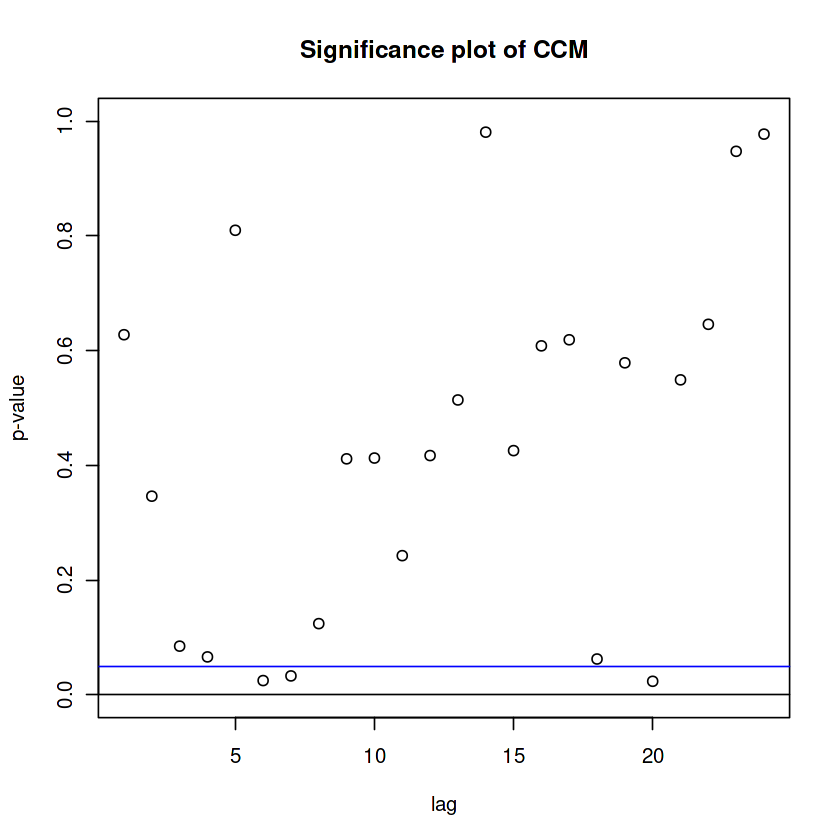

Hit Enter to obtain residual plots: 


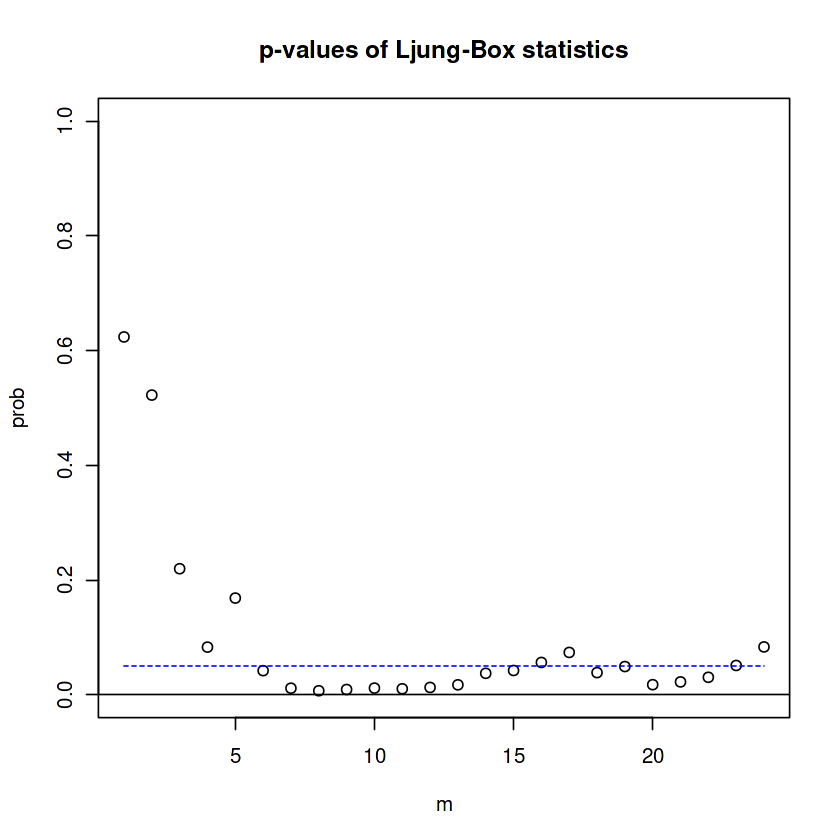

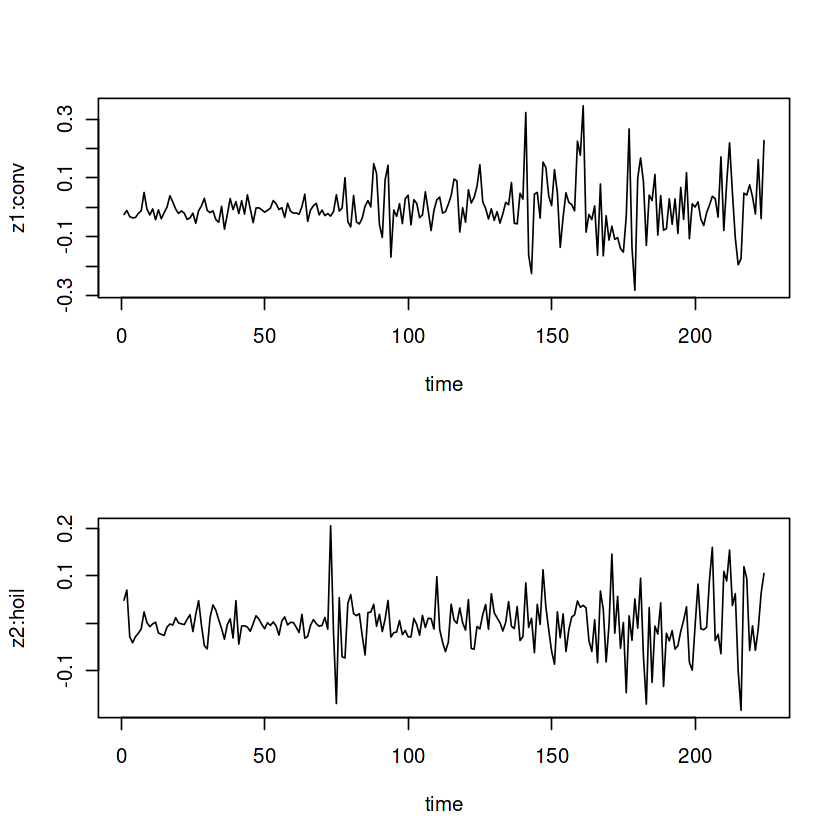

In [44]:
#Se revisan residuales:
MTSdiag(m1_ref)

Como se puede observar, este nuevo modelo genera tanto un mejor ajuste a los datos, medidos por los criterios de información, así como una mejoría en el comportamiento de los residuales.

<a id="7"></a> <br>
### 7. Predicción
A partir del modelo anterior, podemos proceder con la predicción del modelo. Para ello, ya que el modelo con regresores exógenos está sujeto o condicionado a los endógenos, es necesario que se suministre la información de las variables exógenas en la función para poder conocer el pronóstico de las variables de respuesta.

In [47]:
# Debemos suminisrar los valores futuros de las variables exógenas. Para ello, si estos valores se suministran a mano, se deberá hacer en formato de matriz,
#como se muestra en las líneas comentadas. 
        #new=matrix(c(3,2.5), nrow=1, ncol=2)

# Sin embargo, una práctica usual es el considerar los últimos valores de los regresores exógenos. Por ejemplo, los 10 últimos o más recientes.
new=xt[216:226,]
fore_mode1ref=VARXpred(m1_ref, newxt = new, hstep = 10, orig = 0)

Prediction at origin:  226 
Point forecasts (starting with step 1):  
      z1:conv z2:hoil
 [1,] 3.58666 2.86515
 [2,] 3.67420 3.07759
 [3,] 3.69627 3.09497
 [4,] 3.69964 3.11257
 [5,] 3.71485 3.15272
 [6,] 3.77612 3.23631
 [7,] 3.74145 3.17220
 [8,] 3.56849 2.98932
 [9,] 3.26866 2.69691
[10,] 3.24893 2.81739
Corresponding standard errors:  
    z1:conv z2:hoil
    0.08189 0.05184
se1 0.12018 0.06883
se1 0.13823 0.07939
se1 0.14595 0.08658
se1 0.14940 0.09169
se1 0.15127 0.09540
se1 0.15251 0.09814
se1 0.15341 0.10018
se1 0.15407 0.10171
se1 0.15457 0.10286


Como podemos observar, contaremos con el pronóstico de las variables endógenas, a partir de los valores que suministremos de las exógenas.
Esto sucede ya que, como se ha comentado anteriormente, la condicionareidad de los valores de las variables exógenas, dadas las endógenas. Podríamos considerar esta condición como una desventaja de la aplicabilidad directa del modelo. 

En este tutorial aprendimos cómo desarrollar un modelo VARX, así como la aplicación de su pronóstico. Como se comentó anteriormente, este modelo, al considerar en su sistema vectorial la introducción de variables exógenas, las cuales están condicionadas a las variables endógenas, posee la limitante que se deben especificar los valores futuros de las variables exógenas para poder desarrollar el pronóstico de las variables de respuesta o endógenas en el sistema VARX.